In [1]:
import xarray as xr
import os
from dask.distributed import Client
from utils import climatology
from utils.config import TrackerConfig, create_default_config_file
from utils import plot_utils
from utils import cluster
import matplotlib.pyplot as plt

from matplotlib import colors
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
config = TrackerConfig()
#config.to_yaml('config.yaml')

In [5]:
create_default_config_file()


In [11]:
dir_nc_data = config.paths.era5_path
anomaly_variable = config.algorithm.anomaly_variable
time_dim = 'time'
time_group = 'season'
time_group_period = 'DJF'

foutput_min = os.path.join('{}min.nc'.format(config.paths.nc_folder))
foutput_mean = os.path.join('{}mean.nc'.format(config.paths.nc_folder))
foutput_stdev = os.path.join('{}stdev.nc'.format(config.paths.nc_folder))

AttributeError: 'AlgorithmConfig' object has no attribute 'anomaly_variable'

In [ ]:



memory_limit = '5GB'  # Limit memory usage to 8GB per worker
client = Client(n_workers=12,memory_limit=memory_limit)  # Starts a local cluster with memory limits
print(client)


ds = xr.open_mfdataset(os.path.join(dir_nc_data,"*.nc"))

ds = ds.sel(time=ds.time.dt.month.isin([11, 12, 1, 2, 3]))

da = ds[anomaly_variable]

season_min = da.groupby("{}.{}".format(time_dim,time_group)).min(dim=time_dim)
season_mean = da.groupby("{}.{}".format(time_dim,time_group)).mean(dim=time_dim)
season_stdev = da.groupby("{}.{}".format(time_dim,time_group)).std(dim=time_dim)

season_min = season_min.sel(season=time_group_period).drop_vars(time_group)
season_mean = season_mean.sel(season=time_group_period).drop_vars(time_group)
season_stdev = season_stdev.sel(season=time_group_period).drop_vars(time_group)



season_min.to_netcdf(foutput_min, compute=True,mode="w")
season_mean.to_netcdf(foutput_mean, compute=True,mode="w")
season_stdev.to_netcdf(foutput_stdev, compute=True,mode="w")


<Client: 'tcp://127.0.0.1:52091' processes=12 threads=24, memory=55.88 GiB>


In [139]:
minimum =  xr.open_dataset(foutput_min)
mean = xr.open_dataset(foutput_mean)
stdev = xr.open_dataset(foutput_stdev)

In [35]:
foutput_stdev = os.path.join('{}stdev.nc'.format(config.paths.nc_folder))
stdev = xr.open_dataset(foutput_stdev)
da = stdev['daily_t2_min']
da = da >= 3
da_dil = cluster.apply_binary_morph(da,method='dilation')
da_dil = cluster.apply_binary_morph(da_dil,method='fill_holes')

In [42]:
stdev.sel(latitude=slice(70, 20))

<xarray.Dataset> Size: 357kB
Dimensions:       (latitude: 201, longitude: 441)
Coordinates:
  * latitude      (latitude) float32 804B 70.0 69.75 69.5 ... 20.5 20.25 20.0
  * longitude     (longitude) float32 2kB -150.0 -149.8 -149.5 ... -40.25 -40.0
Data variables:
    daily_t2_min  (latitude, longitude) float32 355kB 9.155 9.168 ... 0.9963

In [19]:
ds = xr.open_dataset(r"temp\nc\labeled_nc\clusters_1996.nc")

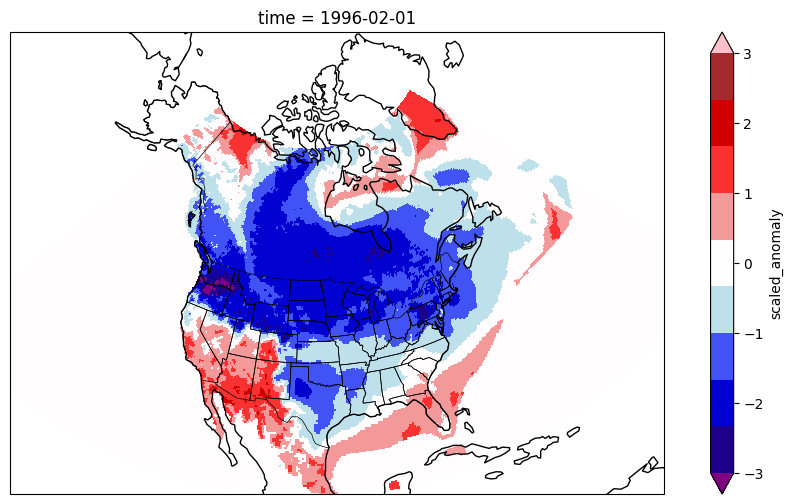

In [41]:
cao_chunk = ds.sel(time = '1996-02-01')
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
plot_utils.da_plot_zero_centered(cao_chunk['scaled_anomaly'])
#cao_chunk['labeled_clusters_filtered'].where(cao_chunk['labeled_clusters_filtered']==7,other=0).plot.contour(transform=ccrs.PlateCarree(),colors='yellow',linewidths=0.3)
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())

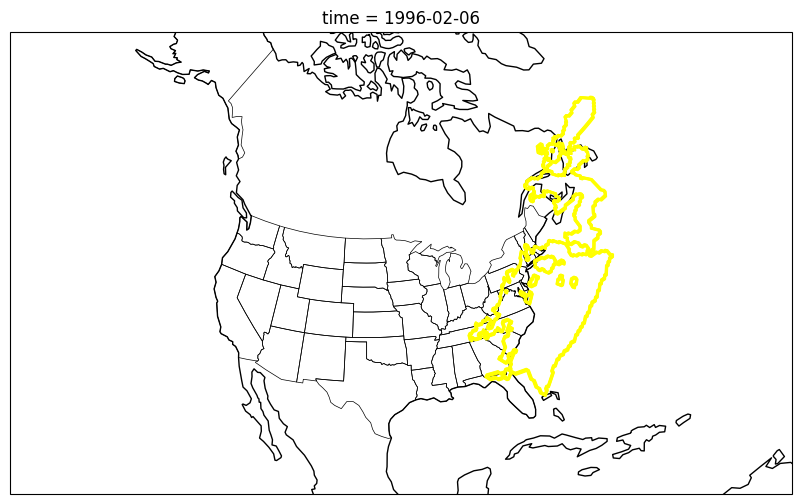

In [38]:
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
#axes = plt.axes(projection=ccrs.PlateCarree())
ds.sel(time='1996-02-06')['labeled_clusters_filtered'].plot.contour(colors='yellow',transform=ccrs.PlateCarree())
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 70),ccrs.PlateCarree())

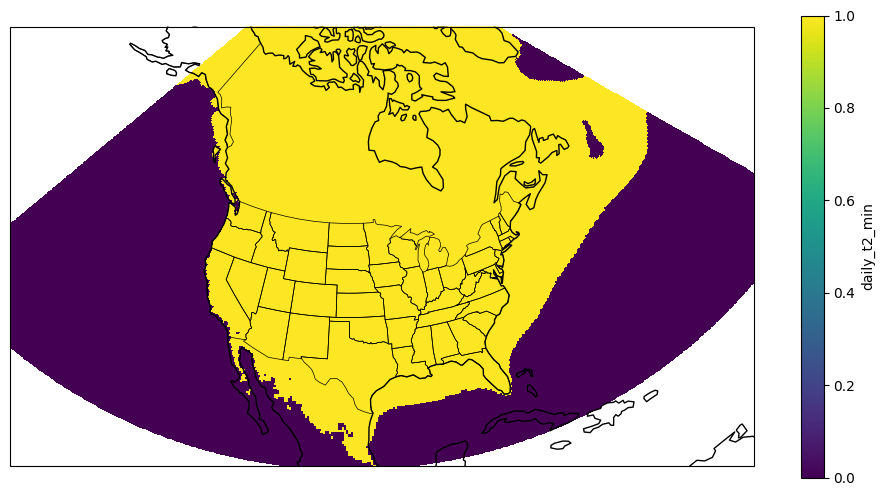

In [38]:
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
#axes = plt.axes(projection=ccrs.PlateCarree())
da.plot(transform=ccrs.PlateCarree())
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 70),ccrs.PlateCarree())

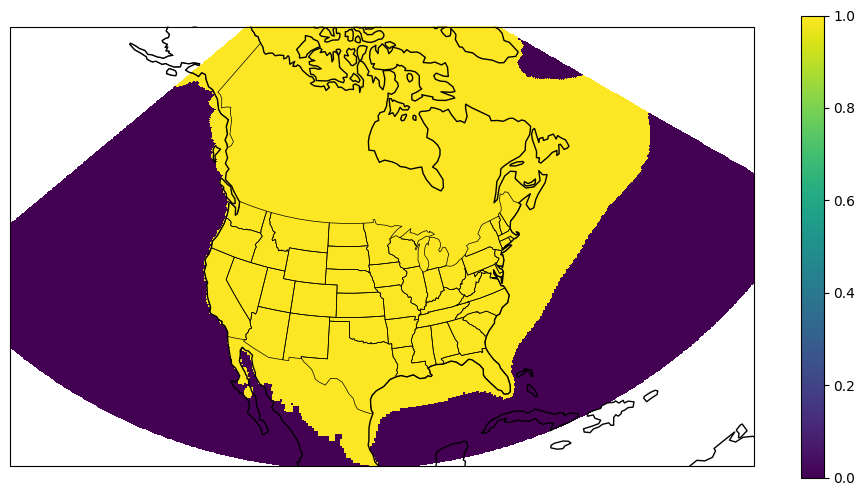

In [39]:
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
#axes = plt.axes(projection=ccrs.PlateCarree())
da_dil.plot(transform=ccrs.PlateCarree())
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 70),ccrs.PlateCarree())

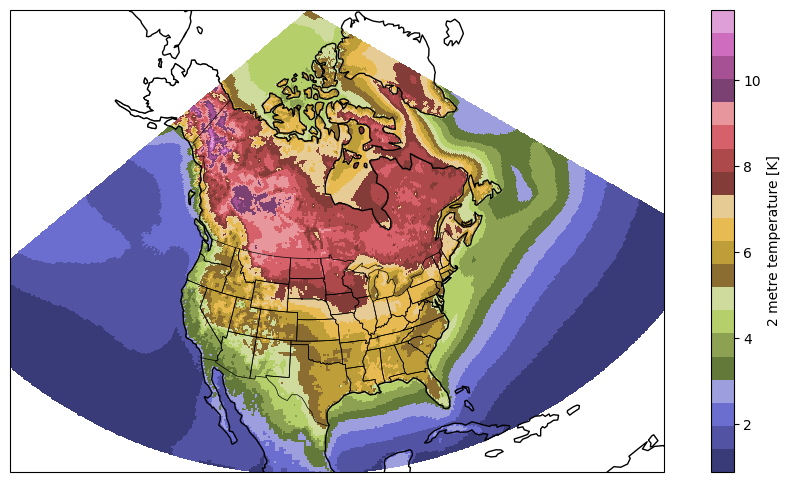

In [141]:
da = stdev['daily_t2_min']
plt.figure(figsize=(12, 6))
plot_utils.map_plot()
plot_utils.da_plot(da,cmap="tab20b")

In [ ]:


z = [-40,-30,-20,-15,-10,-5,-.1,.1,5,10,15,20]
cmap_stdev = colors.LinearSegmentedColormap.from_list("", ["purple","darkblue","blue","lightblue","white","lightcoral","red","darkred","pink"])
norm = colors.TwoSlopeNorm(vmin=np.min(z), vcenter=0, vmax=np.max(z))

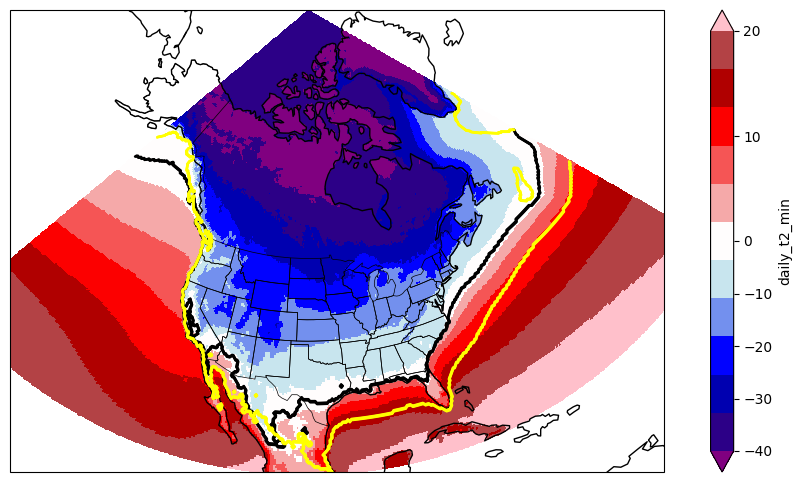

In [145]:
proj_from=ccrs.PlateCarree()
new_cmap_viridis = plot_utils.set_white_color(plt.cm.viridis)
da = (mean['daily_t2_min']-273.15) -1.5 * stdev['daily_t2_min']
plt.figure(figsize=(12, 6))
plot_utils.map_plot()
da.plot(transform=proj_from,cmap=cmap_stdev,norm=norm,levels=z)
(da >= 0).plot.contour(colors='black',transform=proj_from)

da = stdev['daily_t2_min']
(da >= 3).plot.contour(colors='yellow',transform=proj_from)


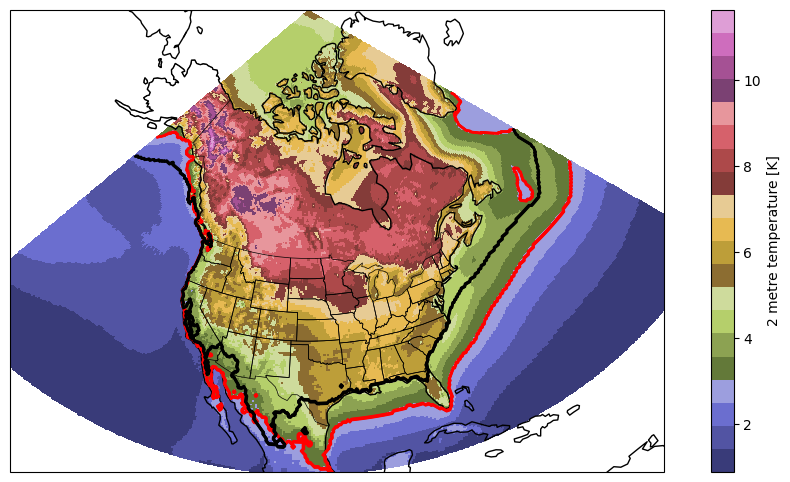

In [ ]:
da = stdev['daily_t2_min']
plt.figure(figsize=(12, 6))
plot_utils.map_plot()
plot_utils.da_plot(da,cmap="tab20b")
(da >= 3).plot.contour(colors='red',transform=proj_from)


da = (mean['daily_t2_min']-273.15) -1.5 * stdev['daily_t2_min']
(da >= 0).plot.contour(colors='black',transform=proj_from)


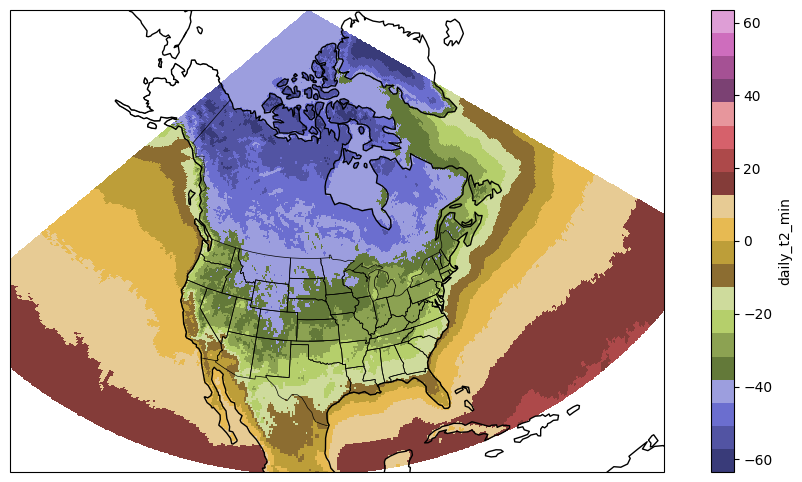

In [147]:

z = [-50,-40,-35,-30,-25,-20,-15,-10,-5,0,5,10]
cmap_stdev = colors.LinearSegmentedColormap.from_list("", ["purple","darkblue","blue","lightblue","white","lightcoral","red","darkred","pink"])
norm = colors.TwoSlopeNorm(vmin=np.min(z), vcenter=0, vmax=np.max(z))

da = (minimum['daily_t2_min']-273.15)
plt.figure(figsize=(12, 6))
plot_utils.map_plot()
#da.plot(transform=proj_from,cmap=cmap_stdev,norm=norm,levels=z)
da.plot(transform=proj_from,cmap="tab20b")



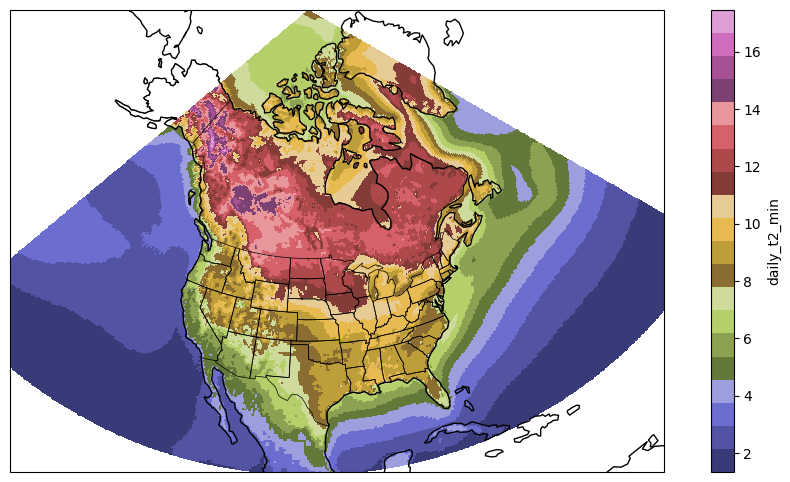

In [151]:
da = 1.5*stdev['daily_t2_min']
plt.figure(figsize=(12, 6))
plot_utils.map_plot()
#da.plot(transform=proj_from,cmap=cmap_stdev,norm=norm,levels=z)
da.plot(transform=proj_from,cmap="tab20b")

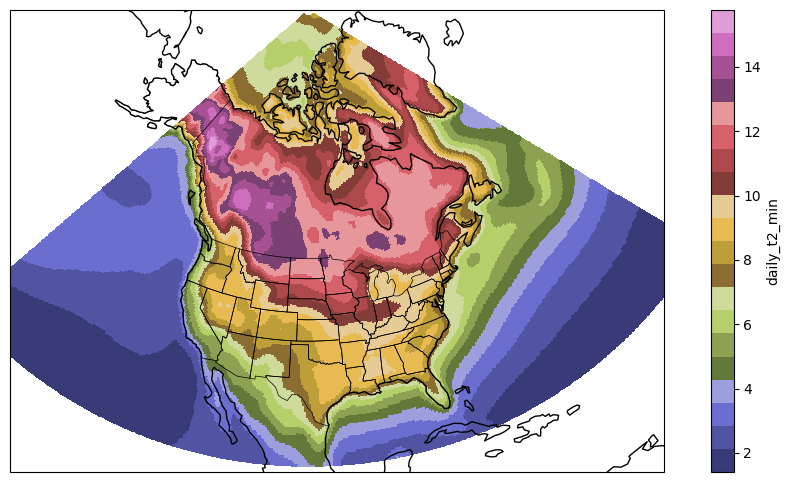

In [169]:
da = 1.5*stdev['daily_t2_min']
#da_dil = cluster.apply_binary_morph(da,method='dilation',s=np.ones((3,3)))
da_dil =  da.rolling(
    latitude=9,    # 3x3 window
    longitude=9,
    center=True    # center the window
).mean()
plt.figure(figsize=(12, 6))
plot_utils.map_plot()
#da.plot(transform=proj_from,cmap=cmap_stdev,norm=norm,levels=z)
da_dil.plot(transform=proj_from,cmap="tab20b")